Connected to base (Python 3.11.7)

In [ ]:
def plot_enforcement_actions(df):
    # Convert 'Date' to datetime and create 'YearMonth' column
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by 'YearMonth' and count the number of enforcement actions
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    # Plot the data using Altair
    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    chart.show()

In [ ]:
def plot_enforcement_actions(df):
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    chart.show()

In [ ]:
def plot_enforcement_actions(df):
    # Convert 'Date' to datetime and create 'YearMonth' column
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by 'YearMonth' and count the number of enforcement actions
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    # Plot the data using Altair
    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    # Save the chart as an HTML file
    chart.save('enforcement_actions_chart.html')
    print("Chart saved as 'enforcement_actions_chart.html'")

df = scrape_enforcement_actions(1, 2023, end_page=5)

if df is not None:
    plot_enforcement_actions(df)

NameError: name 'scrape_enforcement_actions' is not defined

In [ ]:
import pandas as pd
import altair as alt
import time

import warnings 
warnings.filterwarnings('ignore')
alt.renderers.enable("png")

from datetime import datetime

import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://oig.hhs.gov/fraud/enforcement/'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

titles = []
dates = []
links = []
categories = []

enforcement_items = soup.find_all('li', class_='usa-card card--list pep-card--minimal mobile:grid-col-12')

for item in enforcement_items:
    title_tag = item.find('h2', class_='usa-card__heading')
    title = title_tag.get_text(strip=True)
    titles.append(title)

    date_tag = item.find('span', class_='text-base-dark padding-right-105')
    date = date_tag.get_text(strip=True) 
    dates.append(date)

    category_tag = item.find('li', class_='display-inline-block usa-tag text-no-lowercase text-base-darkest bg-base-lightest margin-right-1')
    category = category_tag.get_text(strip=True)
    categories.append(category)

    link_tag = title_tag.find('a', href=True) 
    link = link_tag['href'] if link_tag else 'N/A'
    if not link.startswith('http'):
        full_link = f'https://oig.hhs.gov{link}'
    else:
        full_link = link
    links.append(full_link)

df = pd.DataFrame({
    'Title': titles,
    'Date': dates,
    'Category': categories,
    'Link': links
})

print(df.head())


import time

agencies = []

for full_link in links:
    action_response = requests.get(full_link)
    action_response.raise_for_status()
    action_soup = BeautifulSoup(action_response.text, 'html.parser')

    agency_tag = action_soup.find('span', string='Agency:')
    if agency_tag:
        agency = agency_tag.find_parent('li').get_text(
            strip=True).replace('Agency:', '').strip()
    else:
        agency = 'N/A'

    agencies.append(agency)

    time.sleep(1)

df = pd.DataFrame({
    'Title': titles,
    'Date': dates,
    'Category': categories,
    'Link': links,
    'Agency': agencies
})

print(df.head())



def scrape_enforcement_actions(start_month, start_year, end_page=480):
    if start_year < 2013:
        print("Year must be >= 2013. Please provide a valid year.")
        return

    titles, dates, links, categories = [], [], [], []

    base_url = "https://oig.hhs.gov/fraud/enforcement/"
    page_number = 1

    today = datetime.today()

    while page_number <= end_page:
        url = f"{base_url}?page={page_number}"
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        enforcement_items = soup.find_all(
            "li", class_="usa-card card--list pep-card--minimal mobile:grid-col-12"
        )

        if not enforcement_items:
            print(f"No enforcement items found on page {page_number}. Stopping.")
            break

        valid_data_found = False

        for item in enforcement_items:
            title_tag = item.find("h2", class_="usa-card__heading")
            date_tag = item.find("span", class_="text-base-dark padding-right-105")

            if not title_tag or not date_tag:
                continue

            title = title_tag.get_text(strip=True)
            date = date_tag.get_text(strip=True)
            date_obj = datetime.strptime(date, "%B %d, %Y")

            if date_obj < datetime(start_year, start_month, 1):
                continue

            valid_data_found = True

            titles.append(title)
            dates.append(date)

            category = item.find(
                "li",
                class_="display-inline-block usa-tag text-no-lowercase text-base-darkest bg-base-lightest margin-right-1",
            )
            category_text = category.get_text(strip=True) if category else "N/A"
            categories.append(category_text)

            link = item.find("a", href=True)["href"]
            full_link = f"https://oig.hhs.gov{link}"
            links.append(full_link)

        if not valid_data_found:
            print(f"No valid data found on page {page_number}. Stopping.")
            break

        time.sleep(1)

        page_number += 1

    df = pd.DataFrame(
        {"Title": titles, "Date": dates, "Category": categories, "Link": links}
    )

    filename = f"enforcement_actions_{start_year}_{start_month}_to_present.csv"
    df.to_csv(filename, index=False)

    print(f"Scraping complete. Data saved to {filename}. Total records: {len(df)}")


scrape_enforcement_actions(1, 2023, end_page=480)


def scrape_enforcement_actions(start_month, start_year, end_page=480):
    if start_year < 2013:
        print("Year must be >= 2013. Please provide a valid year.")
        return

    titles, dates, links, categories = [], [], [], []

    base_url = "https://oig.hhs.gov/fraud/enforcement/"
    page_number = 1

    today = datetime.today()

    while page_number <= end_page:
        url = f"{base_url}?page={page_number}"
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        enforcement_items = soup.find_all(
            "li", class_="usa-card card--list pep-card--minimal mobile:grid-col-12"
        )

        if not enforcement_items:
            print(f"No enforcement items found on page {page_number}. Stopping.")
            break

        valid_data_found = False

        for item in enforcement_items:
            title_tag = item.find("h2", class_="usa-card__heading")
            date_tag = item.find("span", class_="text-base-dark padding-right-105")

            if not title_tag or not date_tag:
                continue

            title = title_tag.get_text(strip=True)
            date = date_tag.get_text(strip=True)
            date_obj = datetime.strptime(date, "%B %d, %Y")

            if date_obj < datetime(start_year, start_month, 1):
                continue

            valid_data_found = True

            titles.append(title)
            dates.append(date)

            category = item.find(
                "li",
                class_="display-inline-block usa-tag text-no-lowercase text-base-darkest bg-base-lightest margin-right-1",
            )
            category_text = category.get_text(strip=True) if category else "N/A"
            categories.append(category_text)

            link = item.find("a", href=True)["href"]
            full_link = f"https://oig.hhs.gov{link}"
            links.append(full_link)

        if not valid_data_found:
            print(f"No valid data found on page {page_number}. Stopping.")
            break

        time.sleep(1)

        page_number += 1

    df = pd.DataFrame(
        {"Title": titles, "Date": dates, "Category": categories, "Link": links}
    )

    filename = f"enforcement_actions_{start_year}_{start_month}_to_present.csv"
    df.to_csv(filename, index=False)

    print(f"Scraping complete. Data saved to {filename}. Total records: {len(df)}")


scrape_enforcement_actions(1, 2021, end_page=480)

filename = "enforcement_actions_2021_1_to_present.csv"
df = pd.read_csv(filename)

total_actions = len(df)
print(f"Total number of enforcement actions scraped: {total_actions}")

earliest_action = df.iloc[-1]
print(f"Earliest enforcement action: Date - {earliest_action['Date']}, Title - {earliest_action['Title']}, Link - {earliest_action['Link']}")

                                               Title              Date  \
0  Former Arlington Resident Sentenced To Prison ...  November 7, 2024   
1  Paroled Felon Sentenced To Six Years For Fraud...  November 7, 2024   
2  Former Licensed Counselor Sentenced For Defrau...  November 6, 2024   
3  Macomb County Doctor And Pharmacist Agree To P...  November 4, 2024   
4  Rocky Hill Pharmacy And Its Owners Indicted Fo...  November 4, 2024   

                     Category  \
0  Criminal and Civil Actions   
1  Criminal and Civil Actions   
2  Criminal and Civil Actions   
3  Criminal and Civil Actions   
4  Criminal and Civil Actions   

                                                Link  
0  https://oig.hhs.gov/fraud/enforcement/former-a...  
1  https://oig.hhs.gov/fraud/enforcement/paroled-...  
2  https://oig.hhs.gov/fraud/enforcement/former-l...  
3  https://oig.hhs.gov/fraud/enforcement/macomb-c...  
4  https://oig.hhs.gov/fraud/enforcement/rocky-hi...  
                          

In [ ]:
def plot_enforcement_actions(df):
    # Convert 'Date' to datetime and create 'YearMonth' column
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by 'YearMonth' and count the number of enforcement actions
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    # Plot the data using Altair
    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    # Save the chart as an HTML file
    chart.save('enforcement_actions_chart.html')
    print("Chart saved as 'enforcement_actions_chart.html'")

df = scrape_enforcement_actions(1, 2023, end_page=5)

if df is not None:
    plot_enforcement_actions(df)

Scraping complete. Data saved to enforcement_actions_2023_1_to_present.csv. Total records: 100


In [ ]:
import pandas as pd
import altair as alt

def plot_enforcement_actions(df):
    # Convert 'Date' to datetime and create 'YearMonth' column
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by 'YearMonth' and count the number of enforcement actions
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    # Plot the data using Altair
    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    chart.show()

# Example usage, assuming you have a DataFrame df from previous scraping
# plot_enforcement_actions(df)

In [ ]:
import pandas as pd
import altair as alt

def plot_enforcement_actions(df):
    # Convert 'Date' to datetime and create 'YearMonth' column
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by 'YearMonth' and count the number of enforcement actions
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    # Plot the data using Altair
    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    chart.display()

# Example usage, assuming you have a DataFrame df from previous scraping
# plot_enforcement_actions(df)

In [ ]:
pip install altair_viewer



SyntaxError: invalid syntax (<ipython-input-8-5a785bd31b66>, line 1)

In [ ]:
import pandas as pd
import altair as alt
import altair_viewer

def plot_enforcement_actions(df):
    # Convert 'Date' to datetime and create 'YearMonth' column
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by 'YearMonth' and count the number of enforcement actions
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    # Plot the data using Altair
    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    altair_viewer.show(chart)

# Example usage:
# plot_enforcement_actions(df)

In [ ]:
import altair as alt

# 启用默认渲染器
alt.renderers.enable('default')


RendererRegistry.enable('default')

In [ ]:
import pandas as pd
import altair as alt
import altair_viewer

def plot_enforcement_actions(df):
    # Convert 'Date' to datetime and create 'YearMonth' column
    df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by 'YearMonth' and count the number of enforcement actions
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')

    # Plot the data using Altair
    chart = alt.Chart(monthly_counts).mark_line().encode(
        x='YearMonth:T',
        y='Count:Q',
        tooltip=['YearMonth:T', 'Count:Q']
    ).properties(
        title='Number of Enforcement Actions Over Time (Monthly Aggregation)',
        width=800,
        height=400
    )

    altair_viewer.show(chart)

# Example usage:
# plot_enforcement_actions(df)

In [ ]:
pip install jupyter
jupyter notebook



SyntaxError: invalid syntax (<ipython-input-12-fd791b95e0e4>, line 1)

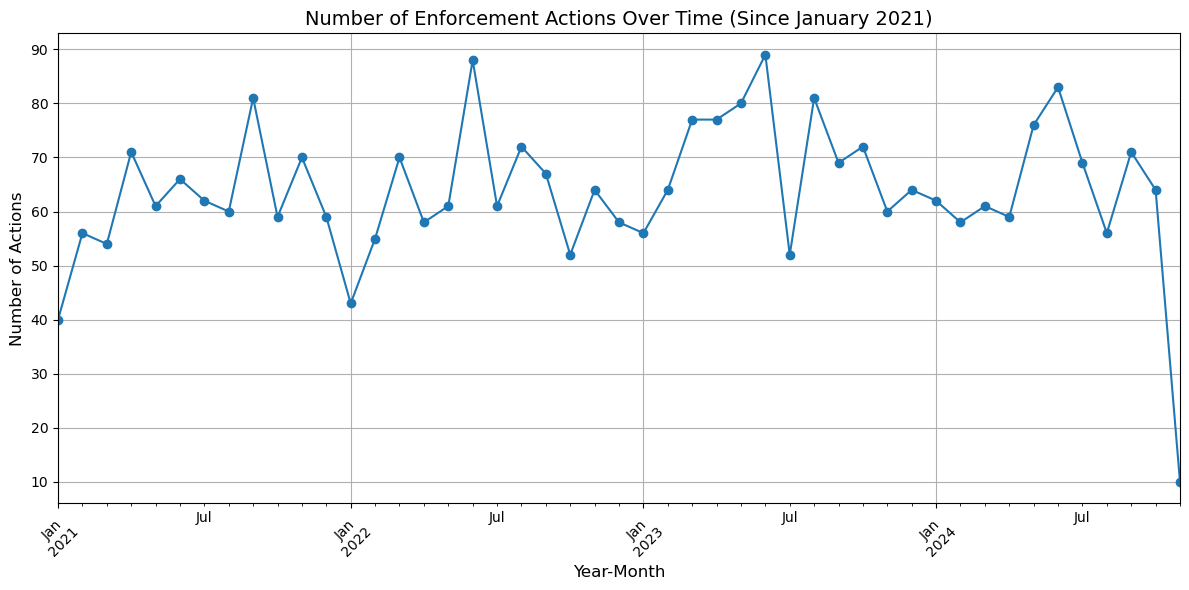

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 文件路径
file_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1_to_present.csv"

# 读取CSV文件
data = pd.read_csv(file_path)

# 确保日期列被正确解析为datetime格式
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# 删除无效的日期
data = data.dropna(subset=['Date'])

# 按年月汇总执法行动数量
data['YearMonth'] = data['Date'].dt.to_period('M')
monthly_counts = data.groupby('YearMonth').size()

# 创建折线图
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='line', marker='o')
plt.title("Number of Enforcement Actions Over Time (Since January 2021)", fontsize=14)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Number of Actions", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 保存图像或展示
plt.savefig("/Users/hahei/Desktop/enforcement_actions_plot.png")  # 保存为文件
plt.show()